In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
pd.options.display.max_rows = 999
import plotly.express as px

In [2]:
from ast import literal_eval
def clean(x):
    return literal_eval(x)

In [3]:
accre_jobs_piped = pd.read_csv('../data/accre_jobs_cleaned.csv', converters={'node_numbers': clean})

# Maggi -- 
    Question: 3 & 4   Calculation of % of actual memory used and mean % for each group

In [4]:
#display the data set
accre_jobs_piped.head(2)

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers
0,0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,1188000,1188028,5120.0,cn,[1531]
1,1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,1188000,1090256,5120.0,cn,[1441]


In [5]:
#look at our groupings of 'state'
accre_jobs_piped['state'].value_counts()
#we will just want to use 'COMPLETED'

COMPLETED              3804644
CANCELLED                 6107
RUNNING                   3108
FAILED                    1406
CANCELLED by 686562        681
OUT_OF_MEMORY               94
TIMEOUT                     80
CANCELLED by 505355         63
CANCELLED by 855431         17
CANCELLED by 782611         13
CANCELLED by 9206            9
CANCELLED by 397600          7
CANCELLED by 200557          6
CANCELLED by 0               5
CANCELLED by 454080          4
CANCELLED by 486541          4
CANCELLED by 199766          4
CANCELLED by 9202            3
CANCELLED by 9201            3
CANCELLED by 483348          3
CANCELLED by 649319          3
CANCELLED by 90423           2
CANCELLED by 895426          2
CANCELLED by 124006          2
CANCELLED by 693461          2
CANCELLED by 199066          2
CANCELLED by 666860          2
CANCELLED by 515423          2
CANCELLED by 791651          2
CANCELLED by 546080          2
CANCELLED by 763605          1
CANCELLED by 781109          1
CANCELLE

In [6]:
#look at our groupings of 'partition'
accre_jobs_piped['partition'].value_counts()
#we will just want to use 'production'

production              3311788
nogpfs                   327652
sam                       79151
pascal                    48004
turing                    39406
debug                      6738
maxwell                    3348
cgw-capra1                   83
cgw-dougherty1               72
cgw-cqs1                     34
cgw-vm-qa-flatearth1          4
cgw-cqs3                      4
devel                         2
cgw-tbi01                     2
cgw-rocksteady                2
Name: partition, dtype: int64

In [7]:
#look at 'exitcode' = 0:0 in 'production' by 'state'
accre_jobs_piped[(accre_jobs_piped['exitcode']=='0:0') & (accre_jobs_piped['partition']=='production')]['state'].value_counts()
#definitely limit to completed based on the 'cancelled*' and 'running' entries

COMPLETED              3302522
CANCELLED                 4449
RUNNING                   2859
CANCELLED by 686562        680
TIMEOUT                     79
CANCELLED by 9201            2
Name: state, dtype: int64

In [8]:
#pull out the initial slice of data for memory usage analysis
memory_use = accre_jobs_piped[(accre_jobs_piped['partition']=='production') & (accre_jobs_piped['exitcode']=='0:0')
                              & (accre_jobs_piped['state']=='COMPLETED')]

In [9]:
memory_use.head(2)

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers
0,0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,1188000,1188028,5120.0,cn,[1531]
1,1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,1188000,1090256,5120.0,cn,[1441]


## Convert Mn to Mc
For Mn, convert to Mc as follows: digits / (cpus/nodes)<br>
For Mc, use the digits as is<br>
usedmem is stated in Mn, but designated as M or possibly with no designation<br>
recmem can be stated in either Mc, Mn, or none<br>
Question: The documentation says that cpus is the total cpus for the job (i.e., not the cpus per node);
    however, some jobs have 1 cpu and 2 nodes, 1 cpu and 51 nodes; so, I don't understand that.<br>
Make two new columns in memory_use reqmem_mc and usedmem_mc

In [10]:
#Convert Mn to Mc, or use as-is if no designation (i.e., assume Mc), removing the Mn or Mc designation as necessary
def convert_reqmem(row):
    if 'Mn' in row['reqmem']:
        cpus = row['cpus'] or 1
        reqmem = int(row['reqmem'][:-2]) / (cpus/row['nodes'])
    elif 'Mc' in row['reqmem']:
        reqmem = int(row['reqmem'][:-2])
    else:
        reqmem = row['reqmem']
    return reqmem

In [11]:
#Add a column of converted reqmem
memory_use['reqmem_mc'] = memory_use.apply(convert_reqmem, axis = 1)

<ipython-input-11-f14a09f44be7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  memory_use['reqmem_mc'] = memory_use.apply(convert_reqmem, axis = 1)


In [13]:
memory_use.head(2)

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,reqmem_mc
0,0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,1188000,1188028,5120.0,cn,[1531],5120.0
1,1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,1188000,1090256,5120.0,cn,[1441],5120.0


In [14]:
#Convert all from Mn to Mc, removing the M designation as necessary
def convert_usedmem(row):
    cpus = row['cpus'] or 1
    if 'M' in row['usedmem']:
        usedmem = float(row['usedmem'][:-1]) / (cpus/row['nodes'])
    else:
        usedmem = float(row['usedmem'])/(cpus/row['nodes'])
    return usedmem

In [15]:
#Add a column of converted usedmem
memory_use['usedmem_mc'] = memory_use.apply(convert_usedmem, axis = 1)

<ipython-input-15-8828f79732d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  memory_use['usedmem_mc'] = memory_use.apply(convert_usedmem, axis = 1)


In [16]:
memory_use.head(2)

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,...,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,reqmem_mc,usedmem_mc
0,0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,...,0:0,COMPLETED,cn1531,1188000,1188028,5120.0,cn,[1531],5120.0,2748.895417
1,1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,...,0:0,COMPLETED,cn1441,1188000,1090256,5120.0,cn,[1441],5120.0,2799.213333


In [17]:
#examples where reqmem in Mc
memory_use[memory_use['reqmem'].str.contains('Mc')][:5]

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,...,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,reqmem_mc,usedmem_mc
705,705,17013893_10,cep,codie,4096Mc,1725.41M,7-00:00:00,2-15:47:46,1,1,...,0:0,COMPLETED,cn421,604800,229666,4096.0,cn,[421],4096.0,1725.41
706,706,17013952_31,cep,codie,4096Mc,1733.61M,7-00:00:00,2-15:44:35,1,1,...,0:0,COMPLETED,cn1394,604800,229475,4096.0,cn,[1394],4096.0,1733.61
2423,2423,17043861_149,cep,sasha,1024Mc,375.44M,1-04:00:00,1-02:35:35,1,1,...,0:0,COMPLETED,cn1090,100800,95735,1024.0,cn,[1090],1024.0,375.44
2424,2424,17043861_159,cep,sasha,1024Mc,375.38M,1-04:00:00,1-04:00:08,1,1,...,0:0,COMPLETED,cn1093,100800,100808,1024.0,cn,[1093],1024.0,375.38
2425,2425,17043861_160,cep,sasha,1024Mc,375.32M,1-04:00:00,1-04:00:22,1,1,...,0:0,COMPLETED,cn1093,100800,100822,1024.0,cn,[1093],1024.0,375.32


In [18]:
#examples where reqmem in Mn
memory_use[(memory_use['reqmem'].str.contains('Mn')) & (memory_use['nodes']>1)][:5]

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,...,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,reqmem_mc,usedmem_mc
3437,3437,17050901_68,winged,lavonda,4096Mn,607.77M,12:00:00,00:02:33,2,2,...,0:0,COMPLETED,cn[1083-1084],43200,153,1024.0,cn,"[1083, 1084]",4096.0,607.77
3439,3439,17050901_70,winged,lavonda,4096Mn,431.89M,12:00:00,00:02:28,2,2,...,0:0,COMPLETED,cn[1083-1084],43200,148,1024.0,cn,"[1083, 1084]",4096.0,431.89
3441,3441,17050901_72,winged,lavonda,4096Mn,504.38M,12:00:00,00:02:30,2,2,...,0:0,COMPLETED,cn[1083-1084],43200,150,1024.0,cn,"[1083, 1084]",4096.0,504.38
3442,3442,17050901_73,winged,lavonda,4096Mn,2054.99M,12:00:00,12:00:13,2,2,...,0:0,COMPLETED,cn[1367-1368],43200,43213,1024.0,cn,"[1367, 1368]",4096.0,2054.99
3443,3443,17050901_74,winged,lavonda,4096Mn,2058.92M,12:00:00,12:00:29,2,2,...,0:0,COMPLETED,cn[1083-1084],43200,43229,1024.0,cn,"[1083, 1084]",4096.0,2058.92


In [24]:
#examples where reqmem in Mc and nodes > 1
memory_use[(memory_use['reqmem'].str.contains('Mc')) & (memory_use['nodes']>1)][:10]

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,...,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,reqmem_mc,usedmem_mc
13436,13436,17105760,summer,buddy,20480Mc,6453.04M,04:40:00,00:00:56,2,1,...,0:0,COMPLETED,cn[1434-1435],16800,56,20480.0,cn,"[1434, 1435]",20480.0,12906.08000
13455,13455,17105819,summer,buddy,20480Mc,7587.56M,04:40:00,00:11:43,2,1,...,0:0,COMPLETED,cn[1434-1435],16800,703,20480.0,cn,"[1434, 1435]",20480.0,15175.12000
13544,13544,17105966,summer,buddy,20480Mc,7587.15M,04:40:00,00:14:03,2,1,...,0:0,COMPLETED,cn[1434-1435],16800,843,20480.0,cn,"[1434, 1435]",20480.0,15174.30000
27258,27258,17125144,summer,buddy,20480Mc,20479.96M,04:40:00,00:17:50,3,1,...,0:0,COMPLETED,cn[1448-1450],16800,1070,20480.0,cn,"[1448, 1450]",20480.0,61439.88000
27560,27560,17125676,summer,buddy,20480Mc,20463.48M,04:40:00,00:34:25,3,1,...,0:0,COMPLETED,cn[1465-1467],16800,2065,20480.0,cn,"[1465, 1467]",20480.0,61390.44000
28763,28763,17126611,summer,buddy,20480Mc,6712.42M,04:40:00,00:03:37,3,1,...,0:0,COMPLETED,cn[1430-1432],16800,217,20480.0,cn,"[1430, 1432]",20480.0,20137.26000
62507,62507,17173216,arra,needham,8192Mc,65535.89M,06:00:00,00:06:44,19,8,...,0:0,COMPLETED,"cn[1281,1283,1297-1298,1300-1301,1325,1355,135...",21600,404,8192.0,cn,"[1281, 1283, 1297, 1298, 1300, 1301, 1325, 135...",8192.0,155647.73875
120493,120493,17255274,belle,osbaldo,8192Mc,0,1-00:00:00,00:01:15,4,12,...,0:0,COMPLETED,"cn[1293,1302,1355-1356]",86400,75,8192.0,cn,"[1293, 1302, 1355, 1356]",8192.0,0.00000
163772,163772,17324222,crowns,tena,5120Mc,9651.66M,2-00:00:00,16:47:47,37,1,...,0:0,COMPLETED,"cn[1094,1125,1266,1277-1279,1293,1298,1301,135...",172800,60467,5120.0,cn,"[1094, 1125, 1266, 1277, 1279, 1293, 1298, 130...",5120.0,357111.42000
167695,167695,17329000,round,shenna,8000Mc,0,10:00:00,00:00:12,2,1,...,0:0,COMPLETED,cn[1291-1292],36000,12,8000.0,cn,"[1291, 1292]",8000.0,0.00000


In [23]:
#it looks like there are some jobs with 0 usedmem, does that make sense?
memory_use['usedmem_mc'].value_counts()
#no it does not, these don't seem valid for evaluating efficiency

0.000000       537283
1.560000        31241
0.197500        30085
1.557500        29904
6.230000        16918
                ...  
1941.335000         1
4828.460000         1
2864.622500         1
3791.320000         1
22.902778           1
Name: usedmem_mc, Length: 887198, dtype: int64

In [33]:
#here's what the data looks like
memory_use[memory_use['usedmem_mc'] ==0]

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,...,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,reqmem_mc,usedmem_mc


In [37]:
#since we'll be calculating ratios to look at efficiency, we don't want any rows where reqmem or usedmem is 0
#also remove a few stray rows where cpus = 0
memory_use = memory_use[(memory_use['reqmem_mc']>0) & (memory_use['usedmem_mc']>0) & (memory_use['cpus']>0)]

In [38]:
#some jobs have fewer cpus than nodes, which doesn't make sense
check_cpus = memory_use[memory_use['cpus']<memory_use['nodes']][['account','cpus','nodes','reqmem', 'usedmem', 'reqmem_mc','usedmem_mc' ]]

In [39]:
#here's what that data looks like
check_cpus
#it's probably not valid for efficiency ratios

,account,cpus,nodes,reqmem,usedmem,reqmem_mc,usedmem_mc
3459,winged,1,3,4096Mn,570.32M,12288.000000,1710.960000
3460,winged,1,4,4096Mn,669.61M,16384.000000,2678.440000
3463,winged,1,3,4096Mn,620.31M,12288.000000,1860.930000
3466,winged,1,4,4096Mn,629.38M,16384.000000,2517.520000
3470,winged,1,3,4096Mn,641.92M,12288.000000,1925.760000
...,...,...,...,...,...,...,...
3710134,burro,3,20,51200Mn,53.06M,341333.333333,353.733333
3713591,burro,3,20,51200Mn,235.39M,341333.333333,1569.266667
3753737,burro,3,20,51200Mn,102.50M,341333.333333,683.333333
3753738,burro,3,20,51200Mn,99.59M,341333.333333,663.933333


In [40]:
#is it limited to particular accounts?
check_cpus['account'].value_counts()
#not particularly

winged          294
chickpeas       293
angelys         196
sharlin         186
wood             62
retailer         52
burro            35
mignonette       15
crowns           13
arra             11
peanuts           6
summer            6
casaba            6
carrot            4
grisette          3
blackberries      3
crab              3
horseradish       1
clara             1
cms_lowprio       1
delblush          1
Name: account, dtype: int64

In [41]:
memory_use['account'].value_counts()

cep              464990
cms              452991
summer           372681
carrot           179941
galia            172315
cms_lowprio      116401
casaba           104134
portabella       103329
bunch             88829
orange            76909
bulk              49270
horseradish       44361
sharlin           43898
sweet             38711
key               34944
mixed             34099
retailer          32049
boysenberries     27957
wood              26226
round             23557
cmsadmin          23421
atemoyas          22084
garlic            19329
wax               17287
alkmene           15532
grisette          15176
celery            14510
winged            14108
sunburst          12876
fresh             11025
chickpeas         10486
regal              9641
large              9019
texas              8606
minnewashta        6555
clara              6324
belle              5687
lychees            5454
st                 5335
muscat             4774
bertanne           4405
seeded          

In [44]:
#remove the rows where cpus < nodes
memory_use = memory_use[memory_use['cpus']>=memory_use['nodes']]

In [45]:
memory_use.head()

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,...,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,reqmem_mc,usedmem_mc
0,0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,...,0:0,COMPLETED,cn1531,1188000,1188028,5120.0,cn,[1531],5120.0,2748.895417
1,1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,...,0:0,COMPLETED,cn1441,1188000,1090256,5120.0,cn,[1441],5120.0,2799.213333
2,2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,...,0:0,COMPLETED,cn1464,1188000,1188020,5120.0,cn,[1464],5120.0,2879.660833
3,3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,...,0:0,COMPLETED,cn1473,1188000,1050632,5120.0,cn,[1473],5120.0,2721.555417
4,4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,...,0:0,COMPLETED,cn1440,1188000,1188003,5120.0,cn,[1440],5120.0,2744.837917


In [60]:
mem_use_by_acct = memory_use.groupby(['account'])[['reqmem_mc', 'usedmem_mc']].sum().reset_index()

In [61]:
mem_use_by_acct

,account,reqmem_mc,usedmem_mc
0,alkmene,1.793044e+07,6.048471e+06
1,almonds,3.529429e+06,6.484339e+05
2,amaranth,2.116267e+07,7.031190e+05
3,angelys,2.457600e+04,1.472480e+03
4,anise,7.154238e+06,2.499509e+06
5,antares,3.655680e+05,2.426081e+05
6,arra,5.558272e+05,3.031670e+05
7,atemoyas,2.390550e+07,1.382488e+06
8,baby,8.780000e+06,7.553961e+05
9,baking,6.439371e+06,1.873608e+06


In [63]:
mem_use_by_acct['avg_usage'] = mem_use_by_acct['usedmem_mc'] / mem_use_by_acct['reqmem_mc']

In [64]:
mem_use_by_acct

,account,reqmem_mc,usedmem_mc,avg_usage
0,alkmene,1.793044e+07,6.048471e+06,0.337330
1,almonds,3.529429e+06,6.484339e+05,0.183722
2,amaranth,2.116267e+07,7.031190e+05,0.033225
3,angelys,2.457600e+04,1.472480e+03,0.059915
4,anise,7.154238e+06,2.499509e+06,0.349375
5,antares,3.655680e+05,2.426081e+05,0.663647
6,arra,5.558272e+05,3.031670e+05,0.545434
7,atemoyas,2.390550e+07,1.382488e+06,0.057831
8,baby,8.780000e+06,7.553961e+05,0.086036
9,baking,6.439371e+06,1.873608e+06,0.290961


In [76]:
mem_plot = mem_use_by_acct[['account','avg_usage']].set_index('account')

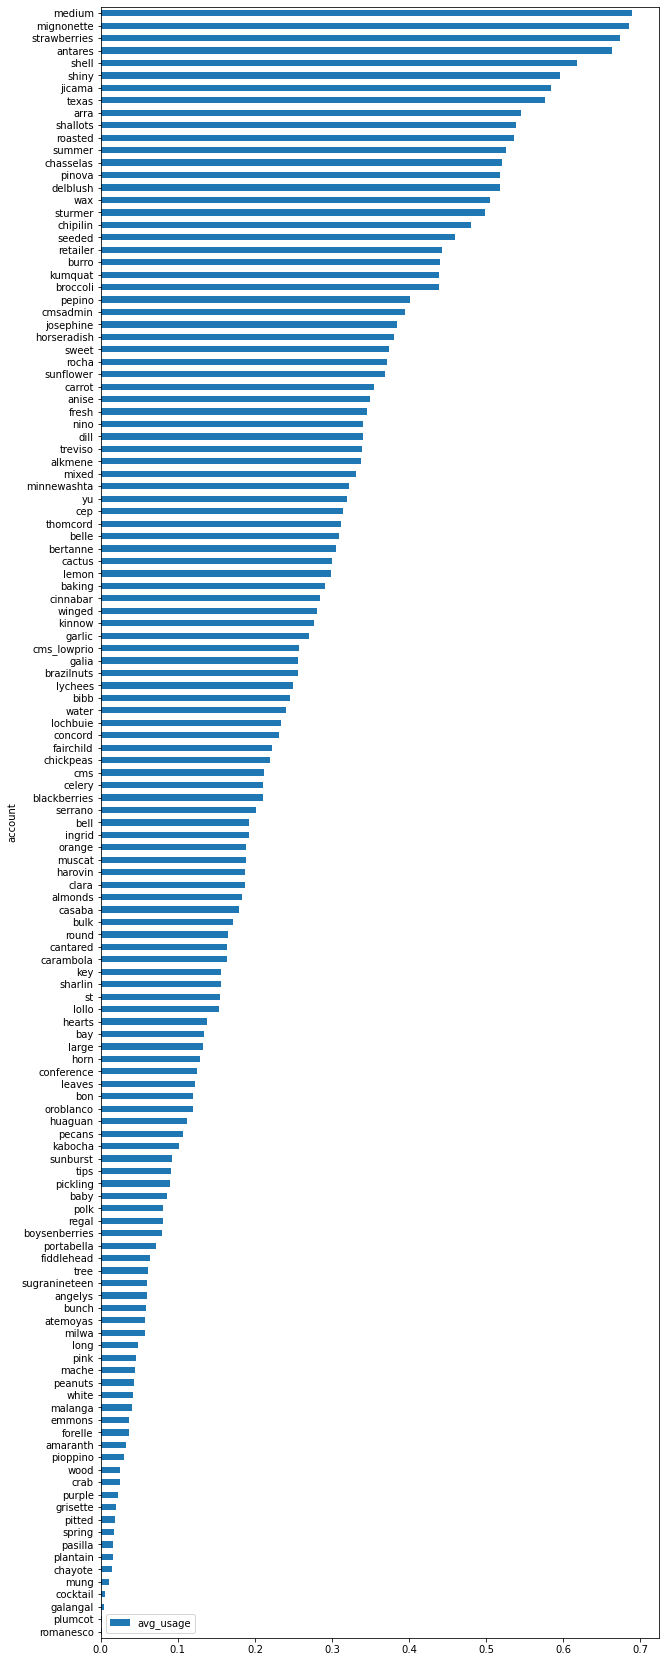

In [88]:
mem_plot.sort_values(['avg_usage']).plot(kind='barh', figsize = (10,30));

In [102]:
px_df=mem_plot.sort_values(['avg_usage'])
#px.line(px_df, 
#        title='Petroleum Reserves Top Ten Countries - Million Metric Tons',
#      labels={'value':'Reserves'})
px.bar(px_df, orientation='h', height = 2000)
num_rows = px_df['avg_usage'].count()
num_rows


131